In [16]:
import random

def generate_random_graph(num_vertices, edge_prob):
    """
    Generates a random graph using the Erdős-Rényi model.

    Parameters:
    - num_vertices: Number of vertices in the graph.
    - edge_prob: Probability of an edge existing between any two vertices.

    Returns:
    - edges: List of edges (tuples) in the graph.
    """
    edges = []
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):  # Avoid duplicate edges and self-loops
            if random.random() < edge_prob:
                edges.append((i, j))
    return edges

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import expm, eigh  # Use scipy for the matrix exponential function

class Simulator:
    def __init__(self, N, H):
        self.N = N
        self.H = H
        
    def classical(self):
        """Simulate the system classically."""
        best_energy = float('inf')
        best_config = None

        # Brute-force over all spin configurations
        for config in range(1 << self.N):
            spins = [1 if (config & (1 << i)) else -1 for i in range(self.N)]
            energy = self.H(spins)
            if energy < best_energy:
                best_energy = energy
                best_config = spins

        return best_config, best_energy
    
    def compute_eigenvalues(self):
        """Compute all possible eigenvalues of the Hamiltonian."""
        eigenvalues = set()
        for config in range(1 << self.N):
            spins = [1 if (config & (1 << i)) else -1 for i in range(self.N)]
            eigenvalue = self.H(spins)
            eigenvalues.add(eigenvalue)
        return sorted(eigenvalues)
    
    def suggest_t(self):
        """Suggest an optimal time t based on the energy gap."""
        eigenvalues = self.compute_eigenvalues()
        if len(eigenvalues) < 2:
            raise ValueError("Insufficient eigenvalues to compute energy gap.")

        gaps = [eigenvalues[i + 1] - eigenvalues[i] for i in range(len(eigenvalues) - 1)]
        delta_E = min(gaps)
        return 1 / delta_E  # Suggest t proportional to the inverse gap
    
    def adiabatic_evolution(simulator, num_steps=100, T=10, backward=False):
        """
        Simulates adiabatic evolution with a transverse field as the initial Hamiltonian.

        Parameters:
            simulator (Simulator): Instance of the simulator.
            num_steps (int): Number of time steps for the evolution.
            T (float): Total time for the evolution.
            backward (bool): If True, evolve backward from final to initial Hamiltonian.

        Returns:
            - states_over_time: List of state vectors at each step.
            - H_ts_over_time: List of instantaneous Hamiltonians at each step.
            - final_state: Final state vector after evolution.
        """
        num_states = 2**simulator.N
        H_initial = np.zeros((num_states, num_states), dtype=complex)

        # Construct the transverse field Hamiltonian
        for i in range(simulator.N):
            for config in range(num_states):
                flipped_config = config ^ (1 << i)  # Flip the i-th spin
                H_initial[config, flipped_config] = -1  # Pauli-X equivalent

        H_final = np.zeros((num_states, num_states), dtype=complex)
        
        # Construct the target (final) Hamiltonian matrix
        for config in range(num_states):
            spins = [1 if (config & (1 << i)) else -1 for i in range(simulator.N)]
            energy = simulator.H(spins)
            H_final[config, config] = energy
            
        # Reverse time points for backward evolution
        if backward:
            time_points = np.linspace(T, 0, num_steps)
            current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Reset state
        else:
            time_points = np.linspace(0, T, num_steps)
            current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Initial state

        states_over_time = []
        H_ts_over_time = []

        for t in time_points:
            s = t / T if not backward else (T - t) / T
            H_t = (1 - s) * H_initial + s * H_final  # Interpolate Hamiltonian
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator for small step
            current_state = U @ current_state  # Apply the evolution

            states_over_time.append((t, current_state))
            H_ts_over_time.append((t, H_t))

        # Return the list of states, Hamiltonians, and the final state
        return states_over_time, H_ts_over_time, current_state
    
    def adiabatic_evolution_with_return(simulator, num_steps=100, T=10):
        """
        Simulates adiabatic evolution starting from H_initial to H_final, then back to H_initial.

        Parameters:
            simulator (Simulator): Instance of the simulator.
            num_steps (int): Number of time steps for the forward and backward evolution.
            T (float): Total time for each phase (forward and backward).

        Returns:
            - states_over_time: List of state vectors at each step.
            - H_ts_over_time: List of instantaneous Hamiltonians at each step.
            - final_state: Final state vector after backward evolution.
        """
        num_states = 2**simulator.N
        H_initial = np.zeros((num_states, num_states), dtype=complex)

        # Construct the transverse field Hamiltonian
        for i in range(simulator.N):
            for config in range(num_states):
                flipped_config = config ^ (1 << i)  # Flip the i-th spin
                H_initial[config, flipped_config] = -1  # Pauli-X equivalent

        H_final = np.zeros((num_states, num_states), dtype=complex)

        # Construct the target (final) Hamiltonian matrix
        for config in range(num_states):
            spins = [1 if (config & (1 << i)) else -1 for i in range(simulator.N)]
            energy = simulator.H(spins)
            H_final[config, config] = energy

        # Adiabatic evolution states
        states_over_time = []
        H_ts_over_time = []

        # Forward evolution: H_initial -> H_final
        time_points_forward = np.linspace(0, T, num_steps)
        current_state = np.ones(num_states, dtype=complex) / np.sqrt(num_states)  # Initial state

        for t in time_points_forward:
            s = t / T
            H_t = (1 - s) * H_initial + s * H_final  # Interpolate Hamiltonian
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator
            current_state = U @ current_state  # Apply the evolution

            states_over_time.append((t, current_state))
            H_ts_over_time.append((t, H_t))

        # Backward evolution: H_final -> H_initial
        time_points_backward = np.linspace(T, 2 * T, num_steps)
        for t in time_points_backward:
            s = (t - T) / T
            H_t = (1 - s) * H_final + s * H_initial  # Interpolate Hamiltonian
            U = expm(-1j * H_t * (T / num_steps))  # Evolution operator
            current_state = U @ current_state  # Apply the evolution

            states_over_time.append((t, current_state))
            H_ts_over_time.append((t, H_t))

        # Return the list of states, Hamiltonians, and the final state
        return states_over_time, H_ts_over_time, current_state


    def compute_overlaps(self, states_over_time, H_ts_over_time):
        """Compute the overlap of the current state with the instantaneous ground state."""
        overlaps = []
        for (t, state), (t_H, H_t) in zip(states_over_time, H_ts_over_time):
            _, eigenvectors = eigh(H_t)  # Compute eigenstates
            ground_state = eigenvectors[:, 0]  # Ground state
            overlap = np.abs(np.dot(np.conjugate(ground_state), state))**2
            overlaps.append((t, overlap))
        return overlaps


In [3]:
def measure(state, simulator, shots=1000):
    """
    Measure the final quantum state and return the observed spins and energies.
    """
    num_states = 2**simulator.N
    probabilities = np.abs(state)**2
    probabilities /= np.sum(probabilities)  # Normalize probabilities

    # Sample outcomes
    outcomes = np.random.choice(num_states, size=shots, p=probabilities)

    # Helper functions
    def config_to_bitstring(config):
        return bin(config)[2:].zfill(simulator.N)

    def bitstring_to_spins(bitstring):
        return [1 if bit == '0' else -1 for bit in bitstring]

    counts = {}
    for outcome in outcomes:
        bitstring = config_to_bitstring(outcome)
        counts[bitstring] = counts.get(bitstring, 0) + 1

    # Calculate energies for each observed state
    energies = {
        bitstring: simulator.H(bitstring_to_spins(bitstring))
        for bitstring in counts
    }

    # Find the minimum-energy configuration
    best_bitstring = min(energies, key=energies.get)
    best_energy = energies[best_bitstring]
    best_spins = bitstring_to_spins(best_bitstring)

    return best_spins, best_energy
    

In [4]:
import random
import itertools
import numpy as np

def generate_random_graph(num_vertices, edge_prob):
    """Generates a random undirected graph as an edge list."""
    edges = []
    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if random.random() < edge_prob:
                edges.append((i, j))
    return edges

# Check if a set of vertices forms a clique
def is_clique_edge_list(edges, vertices):
    for u, v in itertools.combinations(vertices, 2):
        if (u, v) not in edges and (v, u) not in edges:
            return False
    return True

# Find all largest cliques using brute force
def find_all_largest_cliques_brute_force(edges):
    # Extract all unique vertices from the edge list
    vertices = set(u for edge in edges for u in edge)
    max_cliques = []
    max_size = 0

    # Iterate over all subsets of vertices
    for size in range(1, len(vertices) + 1):
        for subset in itertools.combinations(vertices, size):
            if is_clique_edge_list(edges, subset):
                if len(subset) > max_size:
                    max_cliques = [subset]
                    max_size = len(subset)
                elif len(subset) == max_size:
                    max_cliques.append(subset)

    return max_cliques

# Generate graphs until a valid one with a clique of size >= k is found
def generate_valid_clique_graph(num_vertices, edge_prob, k):
    while True:
        edges = generate_random_graph(num_vertices, edge_prob)
        largest_cliques = find_all_largest_cliques_brute_force(edges)
        if any(len(clique) >= k for clique in largest_cliques):
            return edges, largest_cliques



In [20]:
class Cliques:
    def __init__(self, edges, k):
        self.edges = edges  # List of tuples representing edges [(u, v), ...]
        self.k = k  # Desired clique size

    def hamiltonian(self, A=1.0, B=10.0):
        """Define the Ising Hamiltonian for the clique problem."""
        def hamiltonian(spins):
            # First term: enforce clique size
            term1 = (self.k - np.sum(spins)) ** 2
            
            # Updated second term: enforce clique completeness
            term2 = 0
            for u, v in itertools.combinations(range(len(spins)), 2):
                if spins[u] == 1 and spins[v] == 1:  # Both vertices are included
                    if (u, v) not in edges and (v, u) not in edges:  # Edge is missing
                        term2 += 1
            
            # Combine terms
            A, B = 1.0, 10.0  # Weights for terms
            return A * term1 + B * term2
        
        return hamiltonian
    
# Example usage
k = 4  # Desired clique size
num_vertices = 6  # Number of vertices in the graph
edge_prob = 0.5  # Probability of an edge existing between any two vertices

edges, largest_cliques = generate_valid_clique_graph(num_vertices, edge_prob, k)

print("Generated Graph Edges:", edges)
print("Largest Cliques:", largest_cliques)


cliques_problem = Cliques(edges, k)

B = 10
sim = Simulator(num_vertices, cliques_problem.hamiltonian(A=k*B, B=B))

optimal_t = sim.suggest_t()

states_forward, H_ts_over_time, final_state = sim.adiabatic_evolution(num_steps=200, T=optimal_t)
states_backward, H_ts_backward, initial_state = sim.adiabatic_evolution(num_steps=200, T=10, backward=True)

# Measure the final state
best_spins, best_energy = measure(final_state, sim)
print("Final State Measurement:")
print(f"Best Spins: {best_spins}")
print(f"Best Energy: {best_energy}")

Generated Graph Edges: [(0, 1), (0, 2), (0, 3), (0, 5), (1, 2), (1, 3), (2, 3), (2, 4), (3, 4), (3, 5), (4, 5)]
Largest Cliques: [(0, 1, 2, 3)]
Final State Measurement:
Best Spins: [1, 1, 1, 1, -1, -1]
Best Energy: 4.0


In [5]:
def plot_state_probabilities(states_over_time):
    """
    Plots the evolution of state probabilities over time.

    Parameters:
        states_over_time (list): List of tuples (time, state vector) from adiabatic evolution.
    """
    num_states = len(states_over_time[0][1])
    probabilities_over_time = []
    time_points = []

    for t, state in states_over_time:
        probabilities = np.abs(state)**2
        probabilities_over_time.append(probabilities)
        time_points.append(t)

    probabilities_over_time = np.array(probabilities_over_time)
    time_points = np.array(time_points)

    # Plot state probabilities
    plt.figure(figsize=(12, 6))
    colors = cm.viridis(np.linspace(0, 1, num_states))
    for state_idx in range(num_states):
        plt.plot(time_points, probabilities_over_time[:, state_idx], color=colors[state_idx], alpha=0.8)
    plt.title("State Probabilities Over Time")
    plt.xlabel("Time")
    plt.ylabel("Probability")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

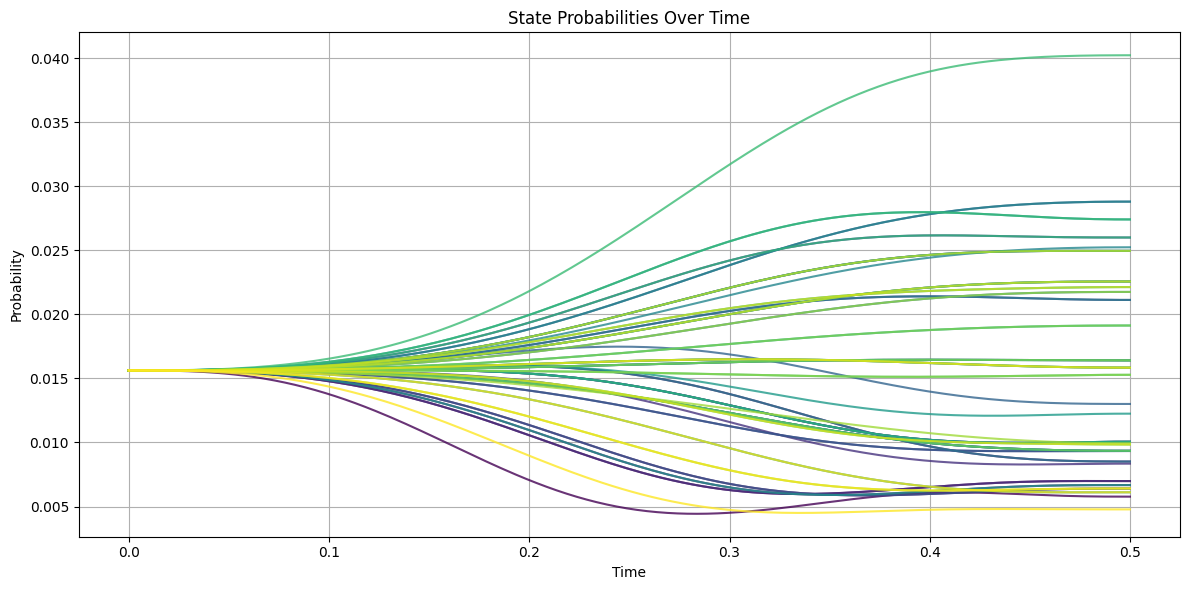

In [7]:
# Plot state probabilities
plot_state_probabilities(states_forward)

In [185]:
def plot_ground_state_overlap(states_over_time, H_ts_over_time):
    """
    Plots the overlap with the instantaneous ground state over time.

    Parameters:
        states_over_time (list): List of tuples (time, state vector) from adiabatic evolution.
        H_ts_over_time (list): List of tuples (time, instantaneous Hamiltonian) from adiabatic evolution.
    """
    overlaps = []
    time_points = []

    for (t, state), (t_H, H_t) in zip(states_over_time, H_ts_over_time):
        time_points.append(t)

        # Use precomputed Hamiltonian to get ground state
        _, eigenvectors = eigh(H_t)
        ground_state = eigenvectors[:, 0]

        # Compute overlap
        overlap = np.abs(np.dot(np.conjugate(ground_state), state))**2
        overlaps.append(overlap)

    time_points = np.array(time_points)
    overlaps = np.array(overlaps)

    # Plot overlap with ground state
    plt.figure(figsize=(12, 6))
    plt.plot(time_points, overlaps, label="Ground State Overlap", color="blue")
    plt.title("Overlap with Ground State Over Time")
    plt.xlabel("Time")
    plt.ylabel("Overlap")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

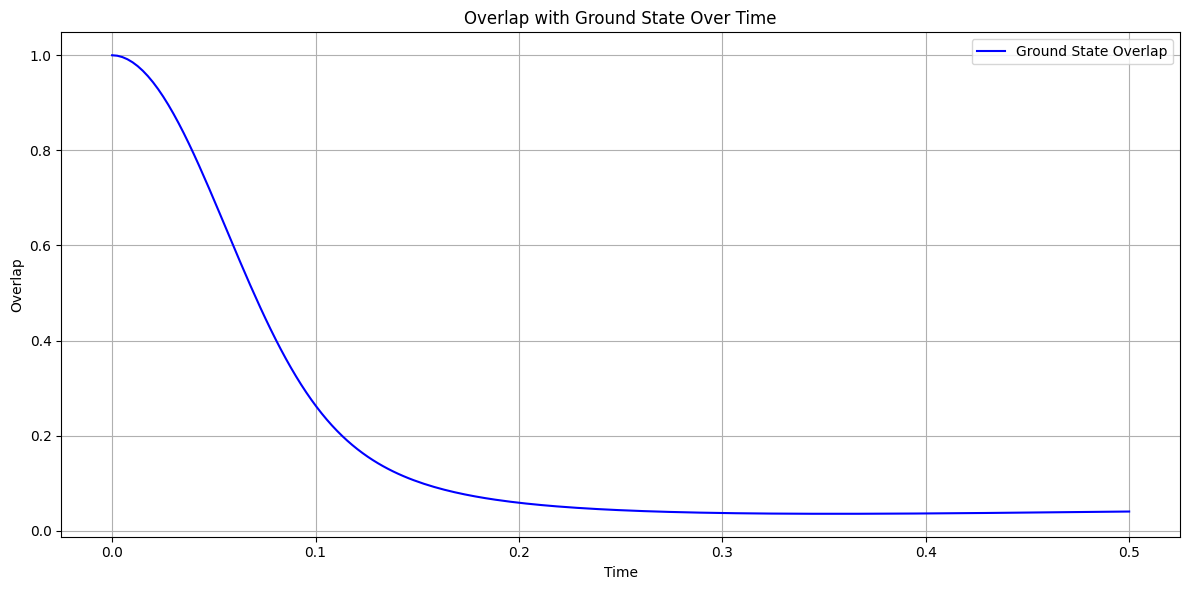

In [186]:
plot_ground_state_overlap(states_forward, H_ts_over_time)

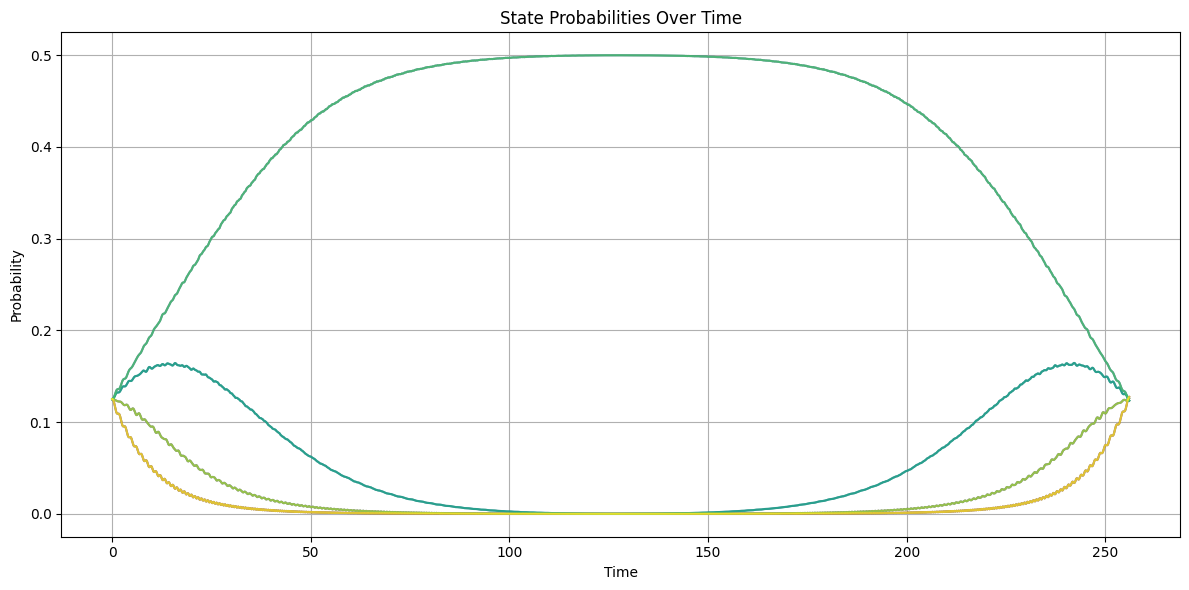

In [7]:
states_over_time, H_ts_over_time, final_state = sim.adiabatic_evolution_with_return(num_steps=1000, T=128)
plot_state_probabilities(states_over_time)

In [6]:
class NumberPartitioning:
    def __init__(self, numbers):
        self.numbers = numbers
    
    def hamiltonian(self):
        """Define the Ising Hamiltonian for the problem."""
        # H = A * (sum(n_i * s_i))^2
        return lambda spins: (np.sum(np.array(self.numbers) * np.array(spins))) ** 2

# Example Input
#numbers = [3, 1, 4, 2, 2]  # Example set of numbers
#numbers = np.random.randint(1, 9, size=5)
numbers = [1, 3, 2]
print(numbers)

np_problem = NumberPartitioning(numbers)

sim = Simulator(len(numbers), np_problem.hamiltonian())

# Classical Simulation
classical_result = sim.classical()
print("Classical Result:", classical_result)

# Suggest an optimal t
optimal_t = sim.suggest_t()
print(f"Suggested optimal t: {optimal_t}")

states_forward, H_ts_over_time, final_state = sim.adiabatic_evolution(num_steps=200, T=optimal_t)
states_backward, H_ts_backward, initial_state = sim.adiabatic_evolution(num_steps=200, T=10, backward=True)

# Measure the final state
best_spins, best_energy = measure(final_state, sim)
print("Final State Measurement:")
print(f"Best Spins: {best_spins}")
print(f"Best Energy: {best_energy}")

[1, 3, 2]
Classical Result: ([-1, 1, -1], np.int64(0))
Suggested optimal t: 0.25
Final State Measurement:
Best Spins: [1, -1, 1]
Best Energy: 0


In [201]:
class GraphPartitioning:
    def __init__(self, edges):
        self.edges = edges  # List of tuples representing edges [(u, v), ...]

    def hamiltonian(self):
        """Define the Ising Hamiltonian for graph partitioning."""
        def hamiltonian(spins):
            # First term: size constraint
            term1 = (np.sum(spins)) ** 2
            
            # Second term: edge penalty
            term2 = sum((1 - spins[u] * spins[v]) / 2 for u, v in self.edges)
            
            # Combine terms
            A, B = 1.0, 1.0  # Weights for terms
            return A * term1 + B * term2
        return hamiltonian


# Example Input
edges = [(0, 1), (1, 2), (2, 3), (3, 0), (0, 2)]  # Example graph (a square with a diagonal)
num_vertices = 4
gp_problem = GraphPartitioning(edges)

sim = Simulator(num_vertices, gp_problem.hamiltonian())

# Classical Simulation
classical_result = sim.classical()
print("Classical Result:", classical_result)

optimal_t = sim.suggest_t()

states_forward, H_ts_over_time, final_state = sim.adiabatic_evolution(num_steps=200, T=optimal_t)
states_backward, H_ts_backward, initial_state = sim.adiabatic_evolution(num_steps=200, T=10, backward=True)

# Measure the final state
best_spins, best_energy = measure(final_state, sim)
print("Final State Measurement:")
print(f"Best Spins: {best_spins}")
print(f"Best Energy: {best_energy}")

Classical Result: ([1, 1, -1, -1], 3.0)
Final State Measurement:
Best Spins: [1, -1, -1, 1]
Best Energy: 3.0


In [214]:
class LogSpinReduction:
    def __init__(self, num_states):
        self.num_states = num_states  # Number of possible states (N)
        self.num_spins = int(np.ceil(np.log2(num_states)))  # Logarithmic reduction
        self.H = None

    def hamiltonian(self):
        """Define a Hamiltonian that enforces constraints using log spins."""
        def hamiltonian(spins):
            # Convert spins to binary variables
            x = [(spin + 1) // 2 for spin in spins]  # Map spins {-1, 1} -> {0, 1}

            # Compute the integer value represented by the spins
            value = sum(2 ** i * x[i] for i in range(len(x)))

            # Constraint: value should be in the range [1, num_states]
            if value < 1 or value > self.num_states:
                return 1e6  # Large penalty for invalid states

            # Example Hamiltonian: penalize deviation from a target value
            target = self.num_states // 2  # Target value for demonstration
            return (value - target) ** 2

        return hamiltonian

num_states = 10  # Number of possible states (N)
log_spin_problem = LogSpinReduction(num_states)

sim = Simulator(num_states, log_spin_problem.hamiltonian())

# Classical Simulation
classical_result = sim.classical()
print("Classical Result:", classical_result)

optimal_t = sim.suggest_t()

states_forward, H_ts_over_time, final_state = sim.adiabatic_evolution(num_steps=200, T=optimal_t)
states_backward, H_ts_backward, initial_state = sim.adiabatic_evolution(num_steps=200, T=10, backward=True)

# Measure the final state
best_spins, best_energy = measure(final_state, sim)
print("Final State Measurement:")
print(f"Best Spins: {best_spins}")
print(f"Best Energy: {best_energy}")

Classical Result: ([1, -1, 1, -1, -1, -1, -1, -1, -1, -1], 0)
Final State Measurement:
Best Spins: [-1, -1, 1, -1, -1, -1, -1, -1, -1, -1]
Best Energy: 1
